<a href="https://colab.research.google.com/github/jlherraiz/deepPRC/blob/main/deepPRC_GFN_UCM_PAPER_APPSCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# deepPRC - POSITRON RANGE CORRECTION WITH Deep Learning
Code from the paper "Deep-Learning Based Positron Range Correction" Applied Sciences (Special Issue - PET Imaging with Deep Learning) https://www.mdpi.com/journal/applsci/special_issues/pet_imaging
### J.L.Herraiz et al. GFN - UCM - 2020

## STEP 0 ) Install all required libraries 

In [ ]:
!pip install -q opencv-python
!pip install -q keras-unet

## STEP 1 ) Load Libraries

In [ ]:
import tensorflow as tf
tf.version.VERSION
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
import sklearn.model_selection as sk

## CHECK GPU

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## IMAGE PARAMETERS

In [ ]:
Nx = 154
Ny = 154
Nz0 = 80

Nt = 8         # Number of simulated volumes
dx = 0.0280
dy = 0.0280
dz = 0.0280    #VOXEL SIZE (cm) ALONG X,Y,Z 

Nz = Nt*Nz0    # Total number of slices

## LOAD IMAGES


In [ ]:
URL = 'https://tomografia.es/data/Ga68_V2_ALL.raw'
PATH_Ga68_V2 = tf.keras.utils.get_file('Ga68_V2.raw',origin=URL)
Ga68_V2_file = np.fromfile(PATH_Ga68_V2, dtype='float32')
Ga68 = Ga68_V2_file.reshape((Nz,Ny,Nx))
#Ga68 = np.concatenate((Ga68,Ga68_V2), axis=0)

60719104/60712960 [==============================] - 7s 0us/step


In [ ]:
URL = 'https://tomografia.es/data/F18_V2_ALL.raw'
PATH_F18_V2 = tf.keras.utils.get_file('F18_V2_ALL.raw',origin=URL)
F18_V2_file = np.fromfile(PATH_F18_V2, dtype='float32')
F18 = F18_V2_file.reshape((Nz,Ny,Nx))
#F18 = np.concatenate((F18,F18_V2), axis=0)

60719104/60712960 [==============================] - 8s 0us/step


## INPUT NORMALIZATION [0..1]


In [ ]:
for k in range(Nz):
    MAX = np.max(Ga68[k,:,:])  # Ga68 is the input --> Normalized to maximum = 1 each slice (both input and output)
    F18[k,:,:] = F18[k,:,:]/MAX
    Ga68[k,:,:] = Ga68[k,:,:]/MAX

## INPUT  /  OUTPUT 

4-D Array with shape [batch, height, width, channels]

In [ ]:
inp_np = np.expand_dims(Ga68,axis=-1) 
out_np = np.expand_dims(F18,axis=-1)

## SPLIT DATA INTO TRAIN AND VALIDATION

In [ ]:
x_train, x_val, y_train, y_val = sk.train_test_split(inp_np, out_np, test_size=0.3, shuffle=True)

## NUMPY TO TENSOR

In [ ]:
# NN requires images with number of pixels which can be divided by 2 multiple times --> Changing from 154 to 160
Nx2=160
Ny2=160

In [ ]:
x_train_tf = tf.convert_to_tensor(x_train, tf.float32)
x_train_tf = tf.image.pad_to_bounding_box(x_train_tf,3,3,Nx2,Ny2)

x_val_tf = tf.convert_to_tensor(x_val, tf.float32)
x_val_tf = tf.image.pad_to_bounding_box(x_val_tf,3,3,Nx2,Ny2)

y_train_tf = tf.convert_to_tensor(y_train, tf.float32)
y_train_tf = tf.image.pad_to_bounding_box(y_train_tf,3,3,Nx2,Ny2)

y_val_tf = tf.convert_to_tensor(y_val, tf.float32)
y_val_tf = tf.image.pad_to_bounding_box(y_val_tf,3,3,Nx2,Ny2)

## SHOW EXAMPLE

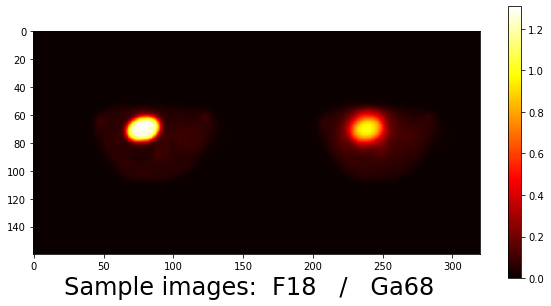

In [ ]:
k=54    # SLICE SELECTED
images = np.squeeze(np.concatenate((y_val_tf[k,:,:,:],x_val_tf[k,:,:,:]), axis=1))

fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(images,cmap='hot')
_ = fig.colorbar(im, ax=ax)
_ = ax.set_xlabel('Sample images:  F18   /   Ga68  ', fontsize=24)

# U-NET

In [ ]:
from keras_unet.models import custom_unet
from keras_unet.utils import get_augmented

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


### DATA AUGMENTATION

In [ ]:
train_gen = get_augmented(x_train_tf, y_train_tf, batch_size=24,
    data_gen_args = dict(width_shift_range=0.3,height_shift_range=0.3,rotation_range=90.0,
        horizontal_flip=True,vertical_flip=True,fill_mode='nearest'))

### MODEL DEFINITION

In [ ]:
model = custom_unet(
    input_shape=(Nx2, Ny2, x_train_tf.shape[3]),
    use_batch_norm=True,
    activation='swish',   #SWISH PROVIDES BETTER RESULTS THAN RELU
    filters=64,
    num_layers=4,
    use_attention=True,
    dropout=0.2,
    output_activation='relu')  #RELU IN THE OUTPUT (POSITIVE BUT NOT LIMITED TO [0..1])

### NEW OPTIMIZERS 

In [ ]:
!pip install -q tfa-nightly
import tensorflow_addons as tfa
opt = tfa.optimizers.RectifiedAdam(lr=1e-3)
opt = tfa.optimizers.Lookahead(opt)

#(Alternative option if the previous section does not work):
#opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam')

In [ ]:
model.compile(optimizer=opt,loss='MeanAbsoluteError')   #l1 NORM

In [ ]:
history = model.fit(train_gen,steps_per_epoch=100, epochs=50, validation_data=(x_val_tf, y_val_tf))  

Epoch 1/5
240/240 [==============================] - 65s 201ms/step - loss: 0.0090 - val_loss: 0.0083
Epoch 2/5
240/240 [==============================] - 49s 203ms/step - loss: 0.0089 - val_loss: 0.0071
Epoch 3/5
240/240 [==============================] - 49s 205ms/step - loss: 0.0089 - val_loss: 0.0068
Epoch 4/5
240/240 [==============================] - 50s 206ms/step - loss: 0.0086 - val_loss: 0.0070
Epoch 5/5
240/240 [==============================] - 50s 207ms/step - loss: 0.0088 - val_loss: 0.0068


### DISPLAY OF RESULTS

Text(0.5, 1.0, 'F18')

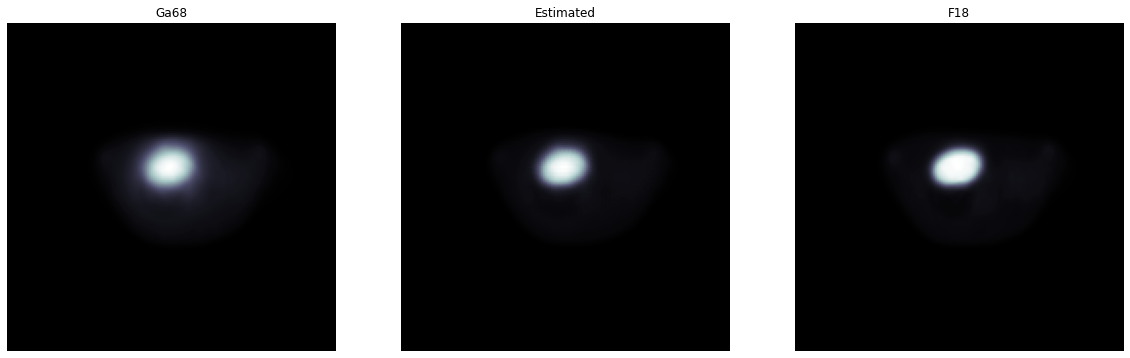

In [ ]:
img_index = 54
test = np.expand_dims(x_val_tf[img_index,:,:,:],axis=0)
estim = model.predict(test)
Ga68_img = np.squeeze(test[:,:,:,0])
estim_img = np.squeeze(estim[:,:,:,0])
F18_img = np.squeeze(y_val_tf[img_index,:,:,:])

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.imshow(Ga68_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Ga68 (Input)')

plt.subplot(1,3,2)
plt.imshow(estim_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Estimated: 68Ga with deepPRC')

plt.subplot(1,3,3)
plt.imshow(F18_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('F18 (Reference)')

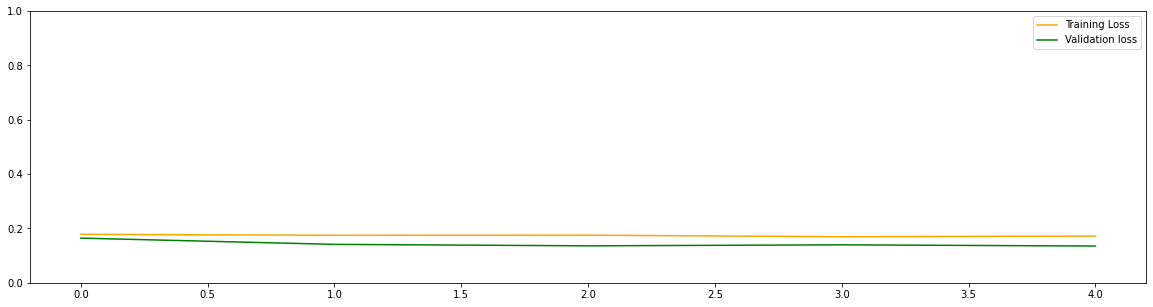

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

loss = np.array(history.history['loss'])
var_loss = np.array(history.history['val_loss'])
ax.plot(20*np.log(1+loss), 'orange', label='Training Loss')
ax.plot(20*np.log(1+var_loss), 'green', label='Validation loss')
ax.set_ylim([0, 1])
ax.legend()
fig.show()

## SAVE LOSS HISTORY

In [ ]:
loss = np.array(history.history['loss'])
var_loss = np.array(history.history['val_loss'])
loss_info = np.transpose(100*np.array([loss,var_loss]))
np.savetxt( "LOSS.csv", loss_info, fmt='%.3f', delimiter='\t')

## SAVE MODEL

In [ ]:
# Save the entire model as a HDF5 file.
model.save('deepPRC.h5') 

## LOAD MODEL

In [ ]:
new_model = tf.keras.models.load_model('deepPRC.h5',compile=False)   # LOADING KERAS MODEL

## EXAMPLE OF APPLICATION TO A SPECIFIC VOLUME (TEST)  We use the initial case (not used for training/validation) 

In [ ]:
test_np = np.zeros([Nz0,Nx,Ny])
maximo = np.zeros([Nz0])
for k in range(Nz0): 
    MAX = np.max(Ga68[k,:,:])  # Ga68 is the input --> Normalized to maximum = 1 each slice (both input and output)
    Ga68[k,:,:] = Ga68[k,:,:]/MAX
    maximo[k]=MAX    #We keep the normalization values to restore them at the end

test_np = np.expand_dims(test_np,axis=-1) 
test_tf = tf.convert_to_tensor(test_np, tf.float32)
test_tf = tf.image.pad_to_bounding_box(test_tf,3,3,Nx2,Ny2) #Padding to make the size easily divisible by 2
#test_tf2 = 2.0*case_tf2-1.0

In [ ]:
import time
t0 = time.time()
estim_img = np.zeros((Nz0,Nx2,Ny2))
for k in range(Nz0):
    test = np.expand_dims(test_tf[k,:,:,:],axis=0)
    estim = new_model.predict(test)
    estim_img[k,:,:] = np.squeeze(estim)*maximo[k]
    
print("Time required for the whole PRC of the Test Volume = ",time.time()-t0," seconds")  # TIME REQUIRED

Time required for the whole PRC of the Test Volume =  3.679273843765259  seconds


In [ ]:
d = np.array(Ga68[0:Nz0,:,:],'float32')
f=open("Image_Ga68.raw","wb")
f.write(d)
f.close()

In [ ]:
d = np.array(F18[0:Nz0,:,:],'float32')
f=open("Image_F18.raw","wb")
f.write(d)
f.close()

In [ ]:
d = np.array(estim_img[0:Nz0,3:157,3:157],'float32')
f=open("Image_Ga68_deepPRC.raw","wb")
f.write(d)
f.close()